In [ ]:
import numpy as np
from sklearn.decomposition import NMF
import math
import warnings
warnings.filterwarnings('ignore')
#  Execute all 'print' statments of a cell instead of only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Problem Formulation

  ## Unconstrained NMF
  NMF receives input matrix $V_{(FxN)}$ and number of factors $K$.

  And it outputs non-negative matrices $W_{FxK}$, $H_{KxN}$: 

  >>>> $V \approx WH$

  Solve:

  >>>>$\hat{W},\hat{H} = \underset{W\geq0,H\geq0}{\operatorname{argmin}} d_{\beta}(V|WH)$ 


  Method

  1.  MU *(Févotte et al., 2009)*:



  >>>>$H \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{W^T(WH)^{\beta-1}}$

  >>>>$W \gets W \odot \dfrac{[V \odot(WH)^{\beta-2}]H^T}{(WH)^{\beta-1}H^T}$

### Implementation

Our goal is to calculate H while untieing W and learn them as network weights.
We imitate Hersheys idea, but we make it for general beta.

The steps as follows:


1.   obtain training data using any classical/out of the box methods, so for a given $v_i$ sample input we have the corresponding $h_i$  coeffecients vector
2.   We built a layer that unrolled this iteration, the layer structure(forward):
 1. 2 Linear layers that replace the $W, W^t$
 2. multiply the element wise tensors as in the iterative method, ensure we don't devide by zero(change zeros to Epsilon at the denominator)
 3. and return the result
3. at the training phase:
  1. after wieghts update we project the weights to non-negative space, this to ensure that the multiplication is kep non-negative(we can check to apply Relu on the nodes output and let W be negative, this can give sparse solution)
  2. loss function used is the MSE, between the network's output and the obtain training one (we may consider simulation and having truth sets)
  3. gradient decent using ADAM was performed. 
  4. we fully used Pytorch operators so we can utilize their autograd functionality(carries out all the backpropogation calculation)

4. initially we had diffuclties in the training phase and it wasn't converging, this was fixed and debugged.
5. we should initialize $h_i$ to feed the first layer, we used a heurstic approach that I found at ScikitLearn package(they have a formulat that manipulate the input and calculates initiale values based on it)

now, the unrolling of this method wroks( I mean converges), we now should define evaluation metric and how we can evaluate it to current available models. there are tuning work to do, and slight variation at the structure, different initializatio, and different loss function.

I want to adopt the approach the Solomon took of calculating the reconstruction error as evaluation metric(it's not clear at your article what other unrolling use for evaluation), to measure on test data that was masked from the training ...etc

moving forward, we may consider train, h and w in parallel in one Network, but from previous discussions with you this will no longer called unrolling. 



## Sparse NMF
NMF receives input matrix $V_{(FxN)}$ and number of factors $K$.

And it outputs non-negative matrices $W_{FxK}$, $H_{KxN}$: 

>>>> $V \approx WH$

Solve:

>>>>$\hat{W},\hat{H} = \underset{W\geq0,H\geq0}{\operatorname{argmin}} d_{\beta}(V|WH) + \mu\| H \|_1$ 


Method

 1.  MU *(Févotte et al., 2009)*:



>>>>$H \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{W^T(WH)^{\beta-1} +\mu}$

>>>>$W \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{W^T(WH)^{\beta-1}}$

## Previous works

### 1. *Hershey, J. R., Roux, J. Le, & Weninger, F. (2014)*

Forward Prop : ?


Back - prop:

$W^{k+1} \gets W^k \odot \dfrac{[\nabla_w^kC]_-}{[\nabla_w^kC]_+}, C - cost function$





## Our Implementation

As we see in previous efforts, all the unrolling methods are 2 stages, the first one is getting truth set data using an iterative method, the second is to train a DNN the relationship obtained in first stage, so for new $V_i$ one can get it's relevant $h_i$.

We want to try a different approach, where all the steps carried out at the DNN, we are unting the $W^l$ to be learnd at the network, and output the $h_i$, in order to achieve that, we feedforward the network using MU and the backprop using updating each parameter by multiplying its value at previous iteration by the ratio of the negative and positive parts of the derivative:

$W^{k+1} \gets W^k \odot \dfrac{[\nabla_w^kD_{KL}]_-}{[\nabla_w^kD_{KL}]_+}, D_{KL}: Kullback-Leibler(divergence)$


Algorithm: 
1. Feedforward per the network architcture
2. update $W^l$ with gradient ratio multiplication $\dfrac{[\nabla_w^kD]_-}{[\nabla_w^kD]_+}$  




>>>>$H \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{W^T(WH)^{\beta-1}}$


>>>>$ H \gets H \odot \dfrac{W^t(V\odot{(WH)^{-1}})}{(W^T\mathbb{1}_{fn})},\space \beta=1$ 

>>>>$ H \gets H \odot \dfrac{W^tV}{W^TWH},\space \beta=2$

### Networks Architictures

#### KL

#### Frobenius

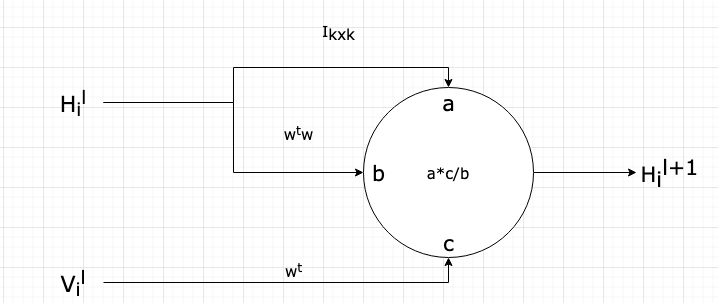

In [ ]:
# Build training data
model_1 = NMF(n_components=22, solver='mu', beta_loss='frobenius', verbose=True)
W = model_1.fit_transform(V)
H = model_1.components_

Epoch 10 reached after 0.018 seconds, error: 33243.653406
Epoch 20 reached after 0.033 seconds, error: 30248.336087
Epoch 30 reached after 0.054 seconds, error: 29135.596438
Epoch 40 reached after 0.068 seconds, error: 28377.534957
Epoch 50 reached after 0.082 seconds, error: 27952.754739
Epoch 60 reached after 0.095 seconds, error: 27706.040843
Epoch 70 reached after 0.109 seconds, error: 27531.920246
Epoch 80 reached after 0.123 seconds, error: 27389.734119
Epoch 90 reached after 0.136 seconds, error: 27265.959032
Epoch 100 reached after 0.150 seconds, error: 27149.567155
Epoch 110 reached after 0.164 seconds, error: 26998.076467
Epoch 120 reached after 0.178 seconds, error: 26829.601895
Epoch 130 reached after 0.192 seconds, error: 26714.370079
Epoch 140 reached after 0.205 seconds, error: 26624.980052
Epoch 150 reached after 0.224 seconds, error: 26551.848766
Epoch 160 reached after 0.238 seconds, error: 26490.390392
Epoch 170 reached after 0.251 seconds, error: 26432.467586
Epoch 

In [ ]:
W.shape
H.shape

(96, 22)

(22, 1350)

In [ ]:
model_1.reconstruction_err_

26321.906385763934

In [ ]:
frobinius(V,W.dot(H))

26321.906385763923

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
V[:,2].shape
model_1.transform(V[:,3])
# shape (n_samples, n_features)

NameError: ignored

## Data

### Mutation

synthetic data, you can check out the source:  https://www.biorxiv.org/content/10.1101/322859v2.full scroll down to "Tests on Synthetic Data". All the data is available at https://www.synapse.org/#!Synapse:syn18497223 , in case you need more than what I sent you (e.g. the W, H matrices).

In [ ]:
# data load
V = np.load('/content/drive/My Drive/Colab Notebooks/synthetic_data/x.syn.many.types.0.5_sp.sp.npy')

In [ ]:
V.shape

(96, 1350)

## Standard NMF Algorithms

[1] N. Gillis, “The Why and How of Nonnegative Matrix Factorization arXiv : 1401 . 5226v2 [ stat . ML ] 7 Mar 2014,” pp. 1–25.

Almost all NMF algorithms designed for (2) use a two-block coordinate descent scheme (exact or inexact; see below), that is, they optimize alternatively over one of the two factors, W or H, while keeping the other fixed. The reason is that the subproblem in one factor is convex. 

More precisely, it is a nonnegative least squares problem (NNLS): for example, for H fixed, we have to solve 
$\underset{W\geq0}{\operatorname{min}} \| X - WH \|^2_F$ 


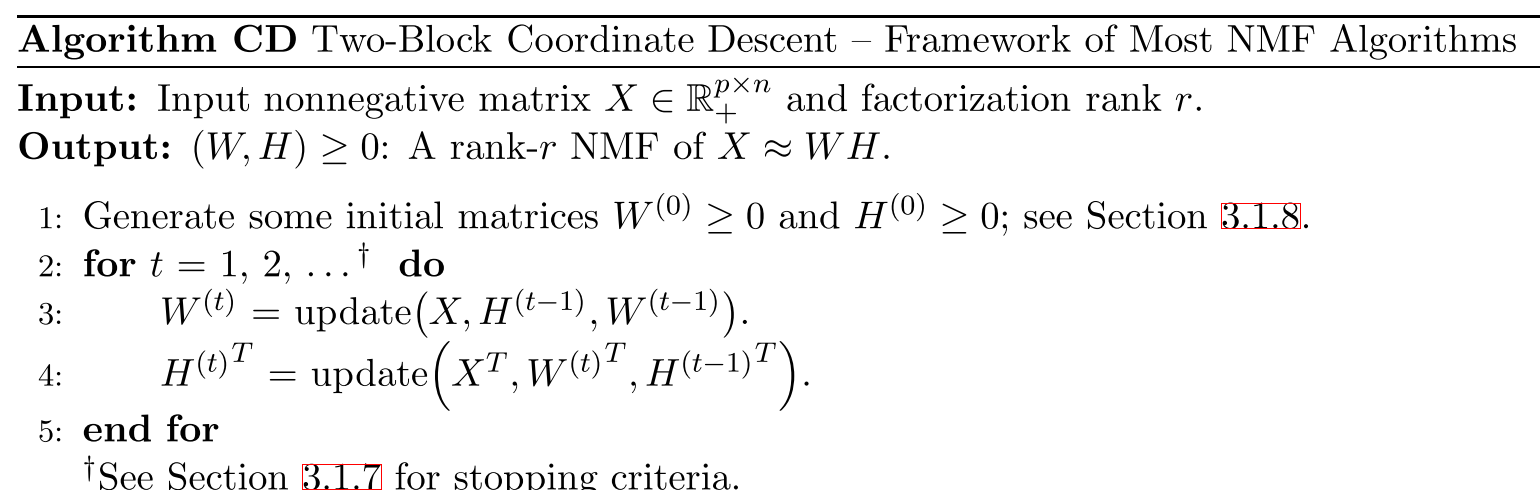

### Lee-Seung - MU

#### Formulation

Févotte, C., & Idier, J. (2011). Algorithms for nonnegative matrix factorization with the β-divergence. Neural Computation, 23(9), 2421–2456. https://doi.org/10.1162/NECO_a_00168



  >>>>$H \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{[W^T(WH)^{\beta-1}]}$

  >>>>$W \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{[W^T(WH)^{\beta-1}]}$

  
*   $\odot, \dfrac{[.]}{[.]}$ denotes component-wise multiplication, division respectivly
*   *Lee and Seung (1999)* prooved convergence for $\beta=1,2$
*   *Kompass (2007)*  generalizes the proof to the case $1 ≤ \beta ≤ 2$




  

#### Code
Scikit in Python has the implementation for multiplicative update with the following beta types:

{'frobenius', 'kullback-leibler', 'itakura-saito'}

In [ ]:
# scikit convention is different from articles, the V is samples x features
model_1 = NMF(n_components=22, solver='mu', beta_loss='frobenius')

In [ ]:
run_list = []
for i in range(0,100):
  model_1 = NMF(n_components=22, solver='mu', beta_loss='frobenius')
  W = model_1.fit_transform(V)
  H = model_1.components_
  run_list.append(model_1)

In [ ]:
import plotly.express as px
[d.reconstruction_err_ for d in run_list]
df = px.data.tips()
fig = px.box(y = [d.reconstruction_err_ for d in run_list])
fig.show()

#### Properties

*   not limited to Euc cost
*   the newly updated value lies in the direction of partial derivative decrease
*   the newly updated value is always nonnegative
*   from above running, there is high variance due to random initialization
*   convergence rate is not the highest one

### Fast Bregman Divergence

#### Formulation
Li, L., Lebanon, G., & Park, H. (2012). Fast bregman divergence NMF using taylor expansion and coordinate descent. Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 307–315. https://doi.org/10.1145/2339530.2339582



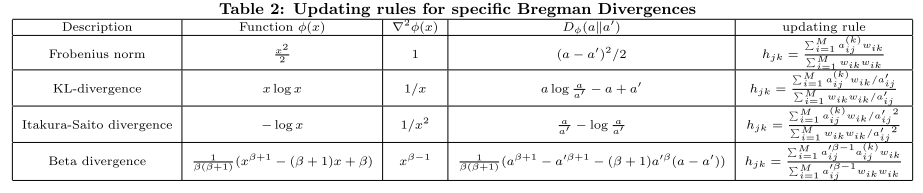

#### Code

In [ ]:
# Fast beta-divergence update, using: Fast Bregman Divergence NMF using Taylor Expansion and Coordinate Descent, Li 2012
# O parameter is a masking matrix, for cross-validation purposes, pass O=1
def sBCD_update(V, W, H, O, obj='kl'):
    n, m = V.shape
    K = W.shape[1]
    V_tag = np.dot(W, H)
    E = np.subtract(V, V_tag)

    if obj == 'kl':
        B = np.divide(1, V_tag) * O
    elif obj == 'euc':
        B = np.ones((V.shape)) * O
    else:  # obj == 'is' Itakura-Saito
        B = np.divide(1, V_tag ** 2) * O

    for k in range(K):
        V_k = np.add(E, np.dot(W[:, k].reshape((n, 1)), H[k, :].reshape((1, m))))
        B_V_k = B * V_k
        # update H
        H[k] = np.maximum(1e-16, (np.dot(B_V_k.T, W[:, k])) / (np.dot(B.T, W[:, k] ** 2)))
        # update W
        W[:, k] = np.maximum(1e-16, (np.dot(B_V_k, H[k])) / (W[:, k] + np.dot(B, H[k] ** 2)))
        E = np.subtract(V_k, np.dot(W[:, k].reshape((n, 1)), H[k, :].reshape((1, m))))

    return W, H

#### Properties


### ALS - Alternating  least squares

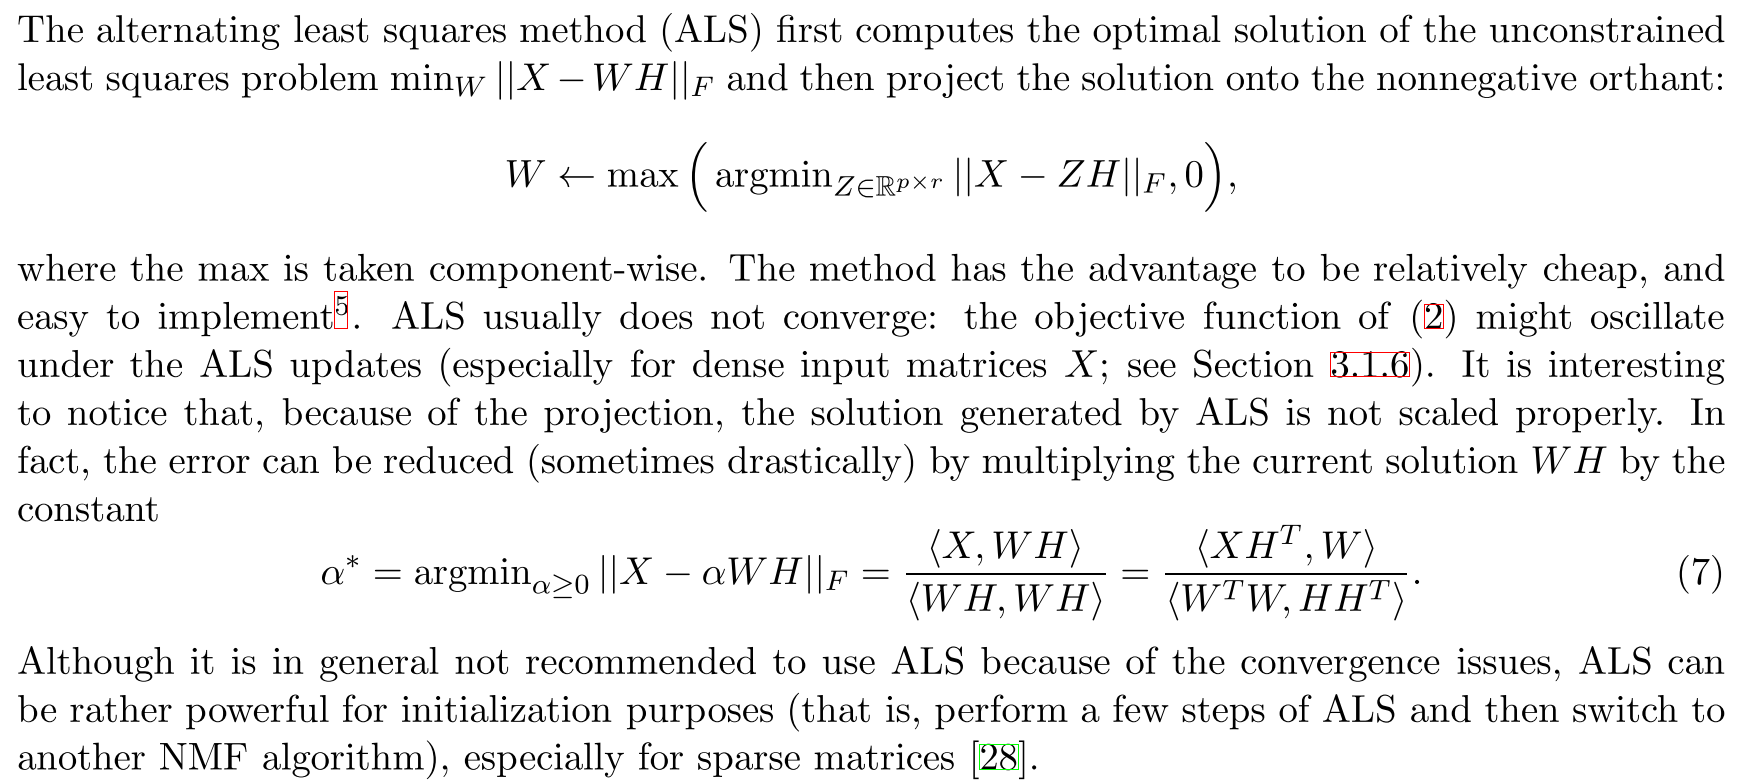

### ANLS - Alternating Nonnegative Least Squares

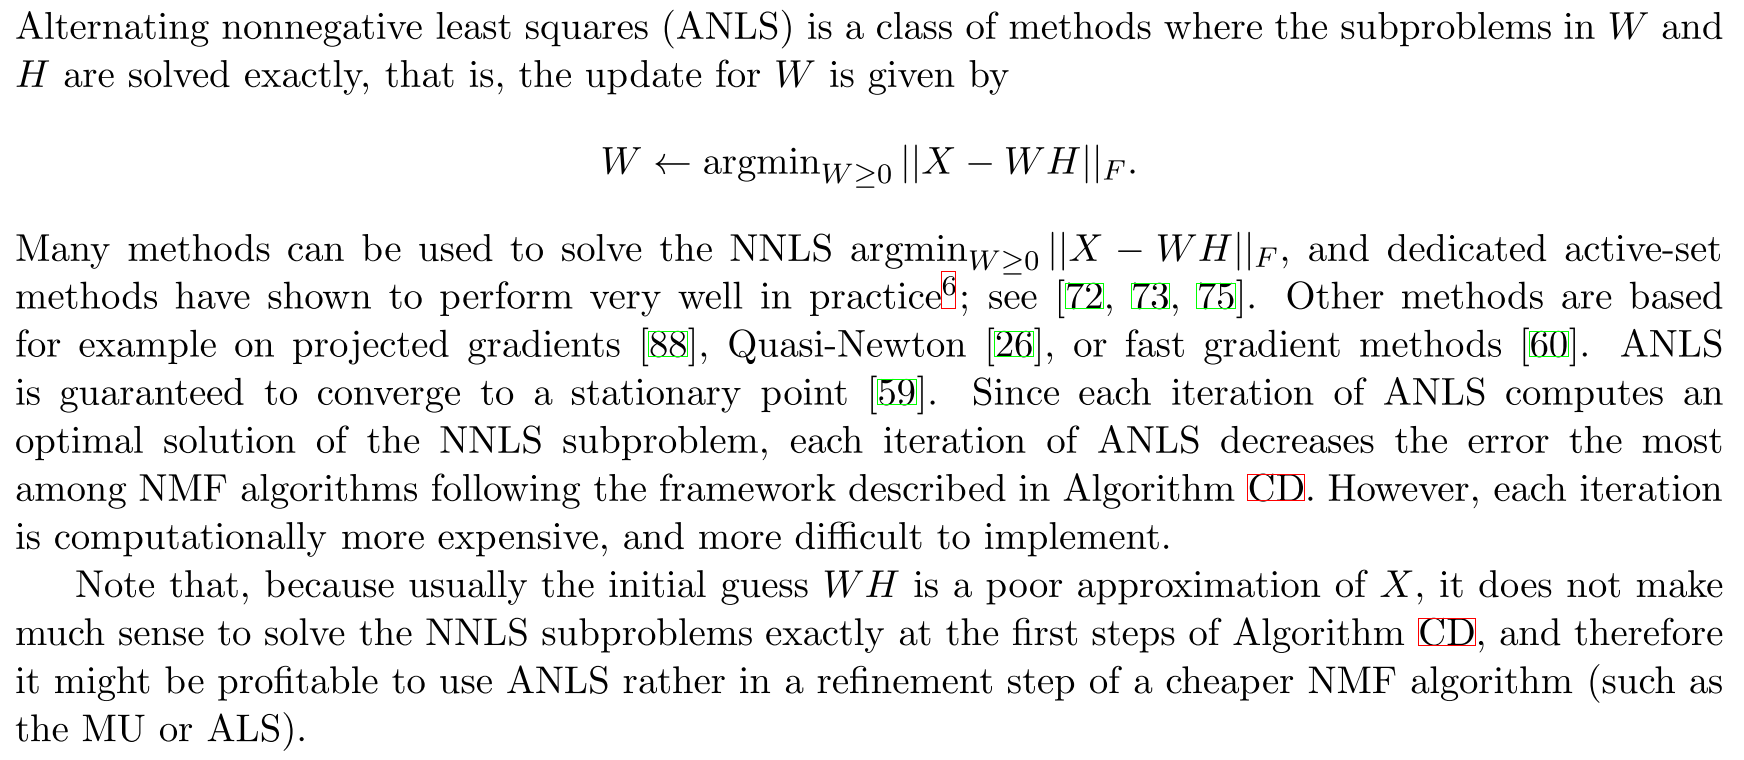

### Hierarchical Alternating Least Squares

Cichocki, Andrzej, and P. H. A. N. Anh-Huy. "Fast local algorithms for
    large scale nonnegative matrix and tensor factorizations."
    IEICE transactions on fundamentals of electronics, communications and
    computer sciences 92.3: 708-721, 2009.

#### Formulation

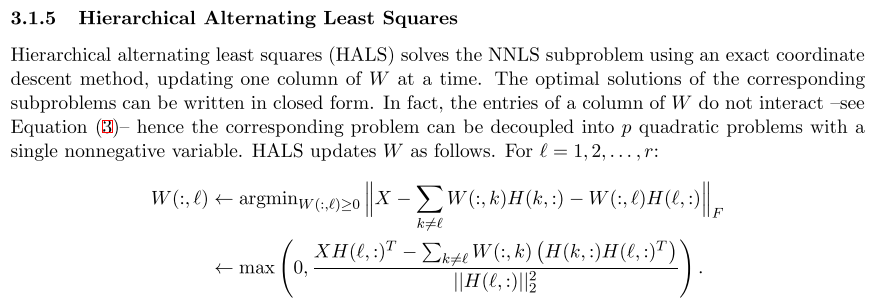

#### Code

In [ ]:
# scikit convention is different from articles, the V is samples x features
model_1 = NMF(n_components=22, solver='cd')

#### Properties



*   Frobinus norm only
*   fast convergence, best today



### Gradient-like algorithms (Lin, 2007b)

Advantages:may “converge” faster than MU rules • 

Drawbacks:nonnegativity constraints must be explicitly handled.

### Newton-like algorithms (Zdunek and Cichocki, 2006)

Advantages: “converge” faster than Gradient-like algos and MU rules • Drawbacks:nonnegativity constraints must be explicitly handled; limited to convex divergences
Expectation-maximization

## initialization

### Random
* initialize (nonnegative) parameters randomly several times

* keep the solution with the lowest final cost

### Strcutural data-driven

* initialize W by clustering of data points V (Kim and Choi, 2007)
* initialize W by singular value decomposition (SVD) of data points V (Boutsidis and Gallopoulos, 2008)
* etc ...

## Cost Functions

### KL-divergence

*(Lee and Seung, 1999)*:

>>>>$d_{KL}(x,y) = x \log \frac{x}{y} -x +y$

* Used for Mutational data
* List item



In [ ]:
# problem is when having zeros in either side (V or WH), how this should be imputed/skipped ?
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0,np.where(b!= 0, a * np.log(a / b) - a + b, 0), 0)) # from wp, zeros aren't counted

### Frobenius

*(Lee and Seung, 1999)*:

>>>>$d_{EUC}(x,y) = (x-y)^2$

In [ ]:
def frobinius(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return math.sqrt(np.sum((a-b)**2))

In [ ]:
#scikit finction 
model_1.reconstruction_err_

### Itakura-Saito
*(Févotte et al., 2009)*:

>>>>$d_{IS}(x,y) = \frac{x}{y} -\log \frac{x}{y} -1$



### $\beta$-divergence
*(Eguchi and Kano., 2001)*:

$d_{\beta}(x,y) =
    \begin{cases}
      \frac{1}{\beta(\beta-1)}(x^\beta + (\beta-1)y^\beta - \beta xy^{\beta-1}) -x +y & \beta \in \mathbb{R} |(0,1)\\
      (x-y)^2 -x +y & {\beta=2}\\
      x \log \frac{x}{y} -x +y & {\beta=1}\\
      \frac{x}{y} -\log \frac{x}{y} -1 & {\beta=0}
    \end{cases}$


In [ ]:
import numpy as np
from sklearn.decomposition import NMF
import math
import warnings
warnings.filterwarnings('ignore')
#  Execute all 'print' statments of a cell instead of only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Knowledge

## Packages


*   [beta-ntf](https://code.google.com/archive/p/beta-ntf/) : Weighted tensor decomposition, all beta-divergences, MM
*   [sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) : L2-norm, gradient-descent, sparsity



## References


*   [Tutorial On NMF](https://www.cs.rochester.edu/u/jliu/CSC-576/NMF-tutorial.pdf)
*   [Build Custom CNN](https://towardsdatascience.com/guide-to-coding-a-custom-convolutional-neural-network-in-tensorflow-bec694e36ad3)
* [deep learning book](https://www.deeplearningbook.org/)
*[MM Optimization Algorithms](https://books.google.co.il/books?id=d9uuDAAAQBAJ&lpg=PR2&pg=PR5#v=onepage&q&f=false)
* [The why and How of NMF](https://www.taylorfrancis.com/books/e/9780429076121)
* [Nonnegative Matrix and Tensor Factorizations](https://books.google.co.il/books?hl=en&lr=&id=KaxssMiWgswC&oi=fnd&pg=PR5&ots=Lte5f8J6MQ&sig=PmW3z25BH0t69fW6s2IpaCsGmlU&redir_esc=y#v=onepage&q&f=false)
